In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import numpy as np

In [2]:
df = pd.read_csv("nft_assets_floor_combined_2022-05-22.csv")

In [3]:
df = df.drop_duplicates(subset=['ownerAddress', 'tokenId','collectionOpenSeaSlug'], keep='last')

# Floor Collection

### Number of unique holders of Floor NFT Collections

## Collection Stats

In [4]:
floor_app = df.query('collectionOpenSeaSlug == "floor-app"').head(1).iloc[0]

In [5]:
floor_app.totalVolume

304.3240899

In [6]:
floor_app.floorPrice

1.13

In [7]:
floor_app.numberOfOwners

332

In [8]:
floor_beta = df.query('collectionOpenSeaSlug == "floor-beta"').head(1).iloc[0]

In [9]:
floor_beta.totalVolume

128.871686720258

In [10]:
floor_beta.floorPrice

0.289

In [11]:
floor_beta.numberOfOwners

680

In [12]:
floor_gen3 = df.query('collectionOpenSeaSlug == "floor-gen3"').head(1).iloc[0]

In [13]:
floor_gen3.totalVolume

93.2167498990002

In [14]:
floor_gen3.floorPrice

0.14

In [15]:
floor_gen3.numberOfOwners

1575

## Other NFT collections held by Floor holders

<AxesSubplot:xlabel='collectionOpenSeaSlug'>

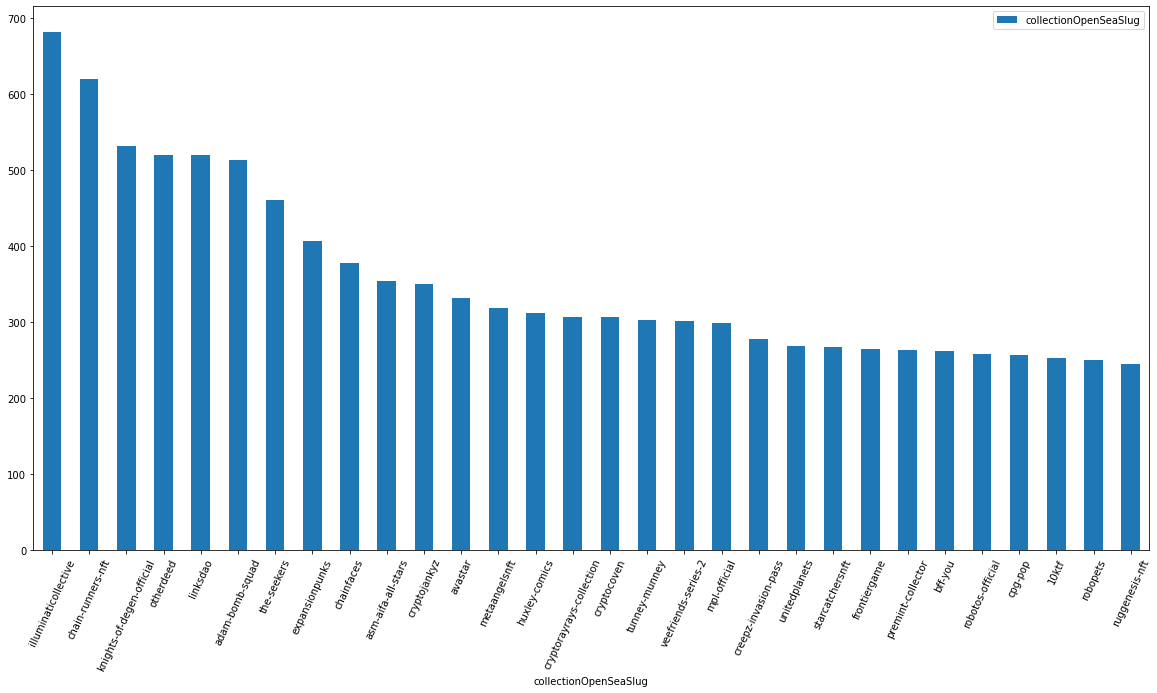

In [16]:
plot_df = df[ (df['collectionOpenSeaSlug'] != "floor-app") & (df['collectionOpenSeaSlug'] != "floor-beta") & (df['collectionOpenSeaSlug'] != "floor-gen3") ]
plot_df = pd.DataFrame(plot_df.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"].count().sort_values(ascending=False))
plot_df.head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)

### What are the most similar Floor holders holding

In [17]:
ocs = df.groupby(["ownerAddress", "collectionOpenSeaSlug"]).count()

In [18]:
ocs_count = ocs['assetContractAddress']
ocs_index = ocs_count.reset_index()
ocs_matrix = ocs_index.pivot(index='ownerAddress', columns='collectionOpenSeaSlug', values='assetContractAddress').fillna(0)

In [19]:
similarity_matrix = pd.DataFrame(
    squareform(pdist(ocs_matrix, metric='cosine')),
    columns = ocs_matrix.index,
    index = ocs_matrix.index
)

In [20]:
similarity_pairs = similarity_matrix.unstack()
similarity_pairs.index.rename(['Address A', 'Address B'], inplace=True)
similarity_pairs = similarity_pairs.to_frame('cosine distance').reset_index()

In [21]:
somewhat_similar = similarity_pairs[
    (similarity_pairs['cosine distance'] < 0.10) 
    & (similarity_pairs['cosine distance'] > 0.03) 
    & (similarity_pairs['Address A'] != similarity_pairs['Address B'])
].sort_values(by='cosine distance')

In [22]:
appended=pd.DataFrame(somewhat_similar.drop(columns='cosine distance').stack().reset_index()).drop(columns=['level_0', 'level_1'])
appended=appended.rename(columns={appended.columns[0]: "address"})
appended=appended.drop_duplicates()
indexed_address= appended.set_index('address')
indexed_df = df.set_index('ownerAddress')
similar_filtered = indexed_df[indexed_df.index.isin(indexed_address.index)].reset_index()
similar_filtered = similar_filtered[ (similar_filtered['collectionOpenSeaSlug'] != "floor-app") & (similar_filtered['collectionOpenSeaSlug'] != "floor-beta") & (similar_filtered['collectionOpenSeaSlug'] != "floor-gen3") ]

<AxesSubplot:xlabel='collectionOpenSeaSlug'>

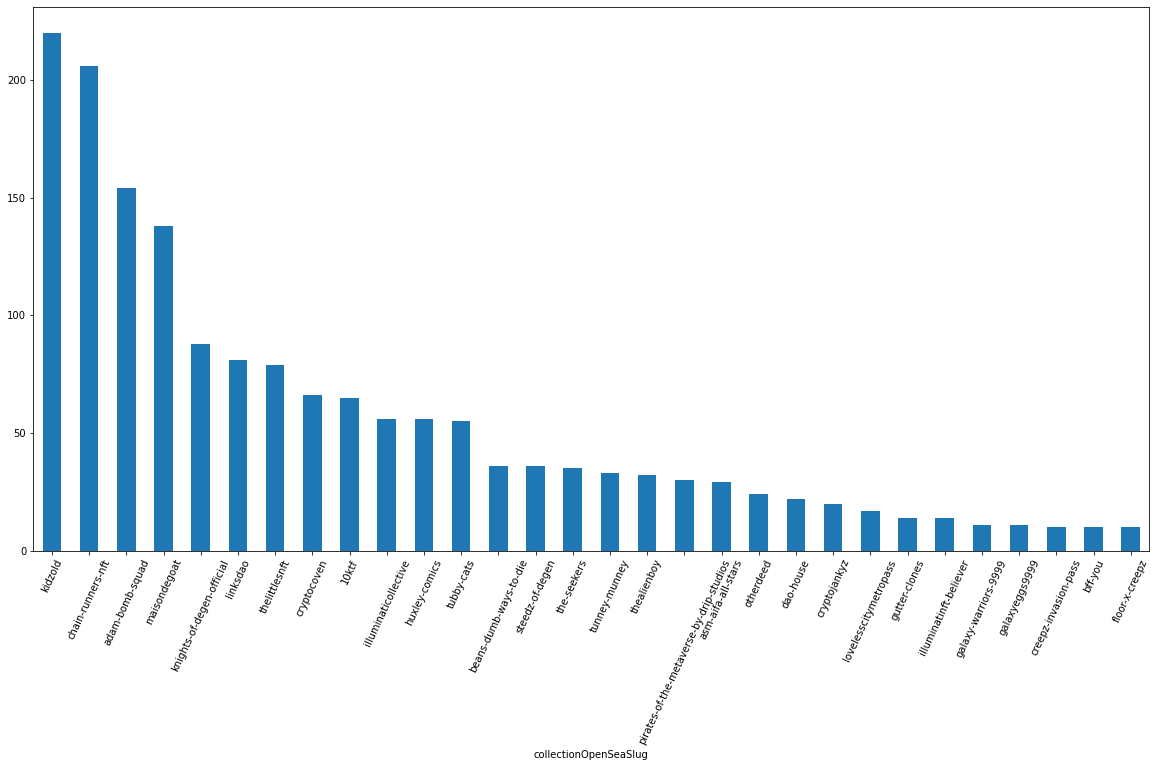

In [23]:
similar_filtered.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"] \
    .count() \
    .sort_values(ascending=False) \
    .head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)

In [24]:
def containsCollections(group, collections):
    strings = group['collectionOpenSeaSlug'].unique()
    contains = np.isin(element=strings, test_elements=collections)
    count = contains.sum()
    if count == len(collections):
        return group

In [25]:
def getSizeOfGroup(df, collections):
    return df.groupby('ownerAddress') \
        .apply(containsCollections, collections=collections) \
        .dropna(how='all') \
        .set_index('ownerAddress') \
        .index \
        .unique() \
        .size

# Illuminati NFT (illuminaticollective)

In [26]:
illuminati_market_data = df.query('collectionOpenSeaSlug == "illuminaticollective"').head(1).iloc[0]

In [27]:
illuminati_market_data['numberOfOwners']

3448

In [28]:
illuminati_market_data['floorPrice']

0.178

In [29]:
illuminati_market_data['totalVolume']

4629.47163624123

In [30]:
#illuminati_market_data['count'] = 8128 # Temporary until we get the count
illuminati_market_data['count']

8128

### How many unique Floor holders hold Illuminati NFT, by Floor app gen

In [31]:
getSizeOfGroup(df, ['illuminaticollective', 'floor-app'])

50

In [32]:
getSizeOfGroup(df, ['illuminaticollective', 'floor-beta'])

135

In [33]:
getSizeOfGroup(df, ['illuminaticollective', 'floor-gen3'])

127

### Unique Floor holders across all gens

In [34]:
illuminati_nfts = indexed_df [ indexed_df['collectionOpenSeaSlug'] ==  'illuminaticollective' ]
illuminati_unique_holders_count = illuminati_nfts.index.unique().size
illuminati_unique_holders_count

227

Unique floor holders in percentage:

In [35]:
(illuminati_unique_holders_count/illuminati_market_data['numberOfOwners'])*100

6.58352668213457

## How many Illuminati NFTs are held by Floor holders:

Note that these Illuminati NFTs are at times "double counted" between floor-app, floor-beta and floor-gen3 collections.This is because we are counting the number of addresses that have a any of the three collections, so a holder of floor-app and floor-beta will be counted twice.

In [36]:
df_containsFloorAndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective', 'floor-app']).dropna(how='all').set_index('ownerAddress')
illuminatis_by_floor_app = df_containsFloorAndIllu[ (df_containsFloorAndIllu['collectionOpenSeaSlug'] == 'illuminaticollective')].index
illuminatis_by_floor_app_count = illuminatis_by_floor_app.size
illuminatis_by_floor_app_count

199

In [37]:
df_containsFloorBetaAndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective', 'floor-beta']).dropna(how='all').set_index('ownerAddress')
illuminatis_by_floor_beta = df_containsFloorBetaAndIllu[ (df_containsFloorBetaAndIllu['collectionOpenSeaSlug'] == 'illuminaticollective')].index
illuminatis_by_floor_beta_count = illuminatis_by_floor_beta.size
illuminatis_by_floor_beta_count

399

In [38]:
df_containsFloorGen3AndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective', 'floor-gen3']).dropna(how='all').set_index('ownerAddress')
illuminatis_by_floor_gen3 = df_containsFloorGen3AndIllu[ (df_containsFloorGen3AndIllu['collectionOpenSeaSlug'] == 'illuminaticollective')].index
illuminatis_by_floor_gen3_count = illuminatis_by_floor_gen3.size
illuminatis_by_floor_gen3_count

374

## Largest Floor and Illuminati holders, Top 20

In [39]:
illuminati_counts = pd.DataFrame(indexed_df[ indexed_df['collectionOpenSeaSlug'] == 'illuminaticollective' ].groupby('ownerAddress').count()['collectionOpenSeaSlug'])

In [40]:
illuminati_counts.sort_values(by='collectionOpenSeaSlug', ascending=False).head(20)

,collectionOpenSeaSlug
ownerAddress,
0x8da288c9fdaa754f2eeadf8145222bd1cc8782ff,15
0x7dd18efd62a5ec66abbacfb4938be3ac6692931c,15
0x9dc6b63e000efe5ea8a0a79fe852941db5f505c0,14
0xee6d73de0d19b72911482f8be59ab6a8e3a780dc,13
0x993a69efe73e3f87df4276e40e81e426385fd2d8,11
0x270487b6377f181a09b3dd2d6bd75100765d2d7d,11
0x6b807b1cc7e5cb402f4d9647042d94411c5e6c34,10
0x31f69e7f8e8ccc4d6ebbc4816ac26e25cef477b8,10
0x7b59793ad075e4ce1e35181054759c080b8d965d,10


## Number of Illuminati NFTs held by Floor holders

In [41]:
number_floor_held_illuminati = illuminati_counts['collectionOpenSeaSlug'].sum()
number_floor_held_illuminati

681

### Percentage of Illuminati NFTs held by Floor holders

In [42]:
number_floor_held_illuminati/illuminati_market_data['count'] * 100

8.378444881889765

### Similar Floor holders that hold an Illuminati NFT

In [43]:
df_containsIllu = similar_filtered.groupby('ownerAddress').apply(containsCollections, collections=['illuminaticollective']).dropna(how='all').set_index('ownerAddress')
df_containsIllu = df_containsIllu[ (df_containsIllu['collectionOpenSeaSlug'] != "illuminaticollective") ]

<AxesSubplot:xlabel='collectionOpenSeaSlug'>

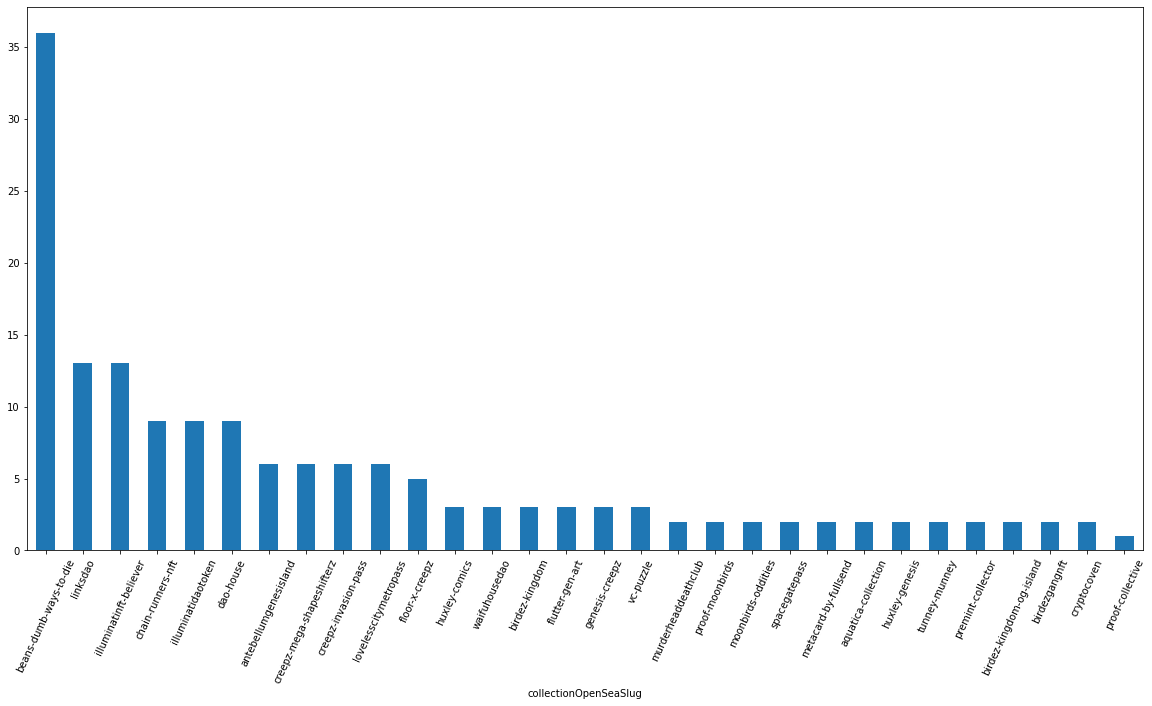

In [44]:
df_containsIllu.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"] \
    .count() \
    .sort_values(ascending=False) \
    .head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)

In [79]:
def nfts_held_by_floor_holders(df, slug, floor_slug):
    df_containsFloorAndIllu = df.groupby('ownerAddress').apply(containsCollections, collections=[slug, floor_slug]).dropna(how='all').set_index('ownerAddress')
    illuminatis_by_floor_app = df_containsFloorAndIllu[ (df_containsFloorAndIllu['collectionOpenSeaSlug'] == slug)].index
    illuminatis_by_floor_app_count = illuminatis_by_floor_app.size
    return illuminatis_by_floor_app_count

In [100]:
def compare(df, slug):
    print("{}:".format(slug))
    market_data = df.query("collectionOpenSeaSlug == '{}'".format(slug)).head(1).iloc[0]
    print(" Unique owners                       : {}".format(market_data['numberOfOwners']))
    print(" Floor price.                        : {} ETH".format(market_data['floorPrice']))
    print(" Total volume                        : {} ETH".format(market_data['totalVolume']))
    
    print(" floor-app  holder count             : {}".format(getSizeOfGroup(df, [slug, 'floor-app'])))
    print(" floor-beta holder count             : {}".format(getSizeOfGroup(df, [slug, 'floor-beta'])))
    print(" floor-gen3 holder count             : {}".format(getSizeOfGroup(df, [slug, 'floor-gen3'])))
    other_slug_nfts = indexed_df [ indexed_df['collectionOpenSeaSlug'] ==  slug ]
    other_slug_unique_holders_count = other_slug_nfts.index.unique().size
    other_slug_unique_holders_count
    print(" Unique Floor holders across all gens: {}".format(other_slug_unique_holders_count))
    print(" Unique Floor holders across all gens: {}%".format((other_slug_unique_holders_count/market_data['numberOfOwners'])*100))
    
    print(" NFTs held by floor-app holders      : {}".format(nfts_held_by_floor_holders(df, slug, 'floor-app')))
    print(" NFTs held by floor-beta holders     : {}".format(nfts_held_by_floor_holders(df, slug, 'floor-beta')))
    print(" NFTs held by floor-gen3 holders     : {}".format(nfts_held_by_floor_holders(df, slug, 'floor-gen3')))
    illuminati_counts = pd.DataFrame(indexed_df[ indexed_df['collectionOpenSeaSlug'] == slug ].groupby('ownerAddress').count()['collectionOpenSeaSlug'])
    print(" Number of NFTs held by Floor holders: {}".format(illuminati_counts['collectionOpenSeaSlug'].sum()))
    
    print(illuminati_counts.sort_values(by='collectionOpenSeaSlug', ascending=False).head(20))
    
    df_containsIllu = similar_filtered.groupby('ownerAddress').apply(containsCollections, collections=[slug]).dropna(how='all').set_index('ownerAddress')
    df_containsIllu = df_containsIllu[ (df_containsIllu['collectionOpenSeaSlug'] != slug) ]
    
    df_containsIllu.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"] \
    .count() \
    .sort_values(ascending=False) \
    .head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)


illuminaticollective:
 Unique owners                       : 3448
 Floor price.                        : 0.178 ETH
 Total volume                        : 4629.47163624123 ETH
 floor-app  holder count             : 50
 floor-beta holder count             : 135
 floor-gen3 holder count             : 127
 Unique Floor holders across all gens: 227
 Unique Floor holders across all gens: 6.58352668213457%
 NFTs held by floor-app holders      : 199
 NFTs held by floor-beta holders     : 399
 NFTs held by floor-gen3 holders     : 374
 Number of NFTs held by Floor holders: 681
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x8da288c9fdaa754f2eeadf8145222bd1cc8782ff                     15
0x7dd18efd62a5ec66abbacfb4938be3ac6692931c                     15
0x9dc6b63e000efe5ea8a0a79fe852941db5f505c0                     14
0xee6d73de0d19b72911482f8be59ab6a8e3a780dc                     13
0x993a69efe73e3f87df4276e40e8

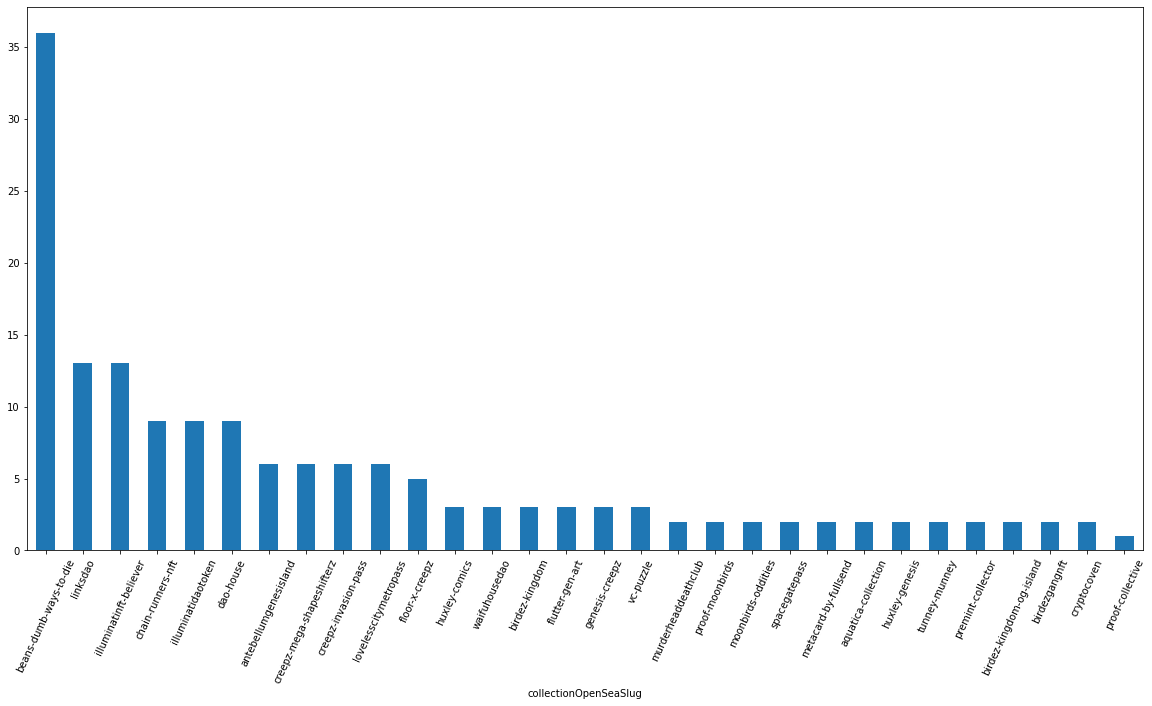

In [101]:
compare(df, "illuminaticollective")

linksdao:
 Unique owners                       : 5253
 Floor price.                        : 0.2879 ETH
 Total volume                        : 5188.92676135105 ETH
 floor-app  holder count             : 76
 floor-beta holder count             : 154
 floor-gen3 holder count             : 209
 Unique Floor holders across all gens: 301
 Unique Floor holders across all gens: 5.730059013896821%
 NFTs held by floor-app holders      : 124
 NFTs held by floor-beta holders     : 264
 NFTs held by floor-gen3 holders     : 357
 Number of NFTs held by Floor holders: 520
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x6cce9bae11b01e9fff30dbe790f64b459a614b0f                     13
0xd9a93a78df096a34b08268c44d3f0f48f51aac85                      8
0x37c8deabe13bd8e1ab0d4eeeaef88a8c5ae4d926                      7
0x578d6e2ed09572d546cf18e659036294842b94cb                      7
0xf90e718487913ead0b17ebb757cb662cb7685

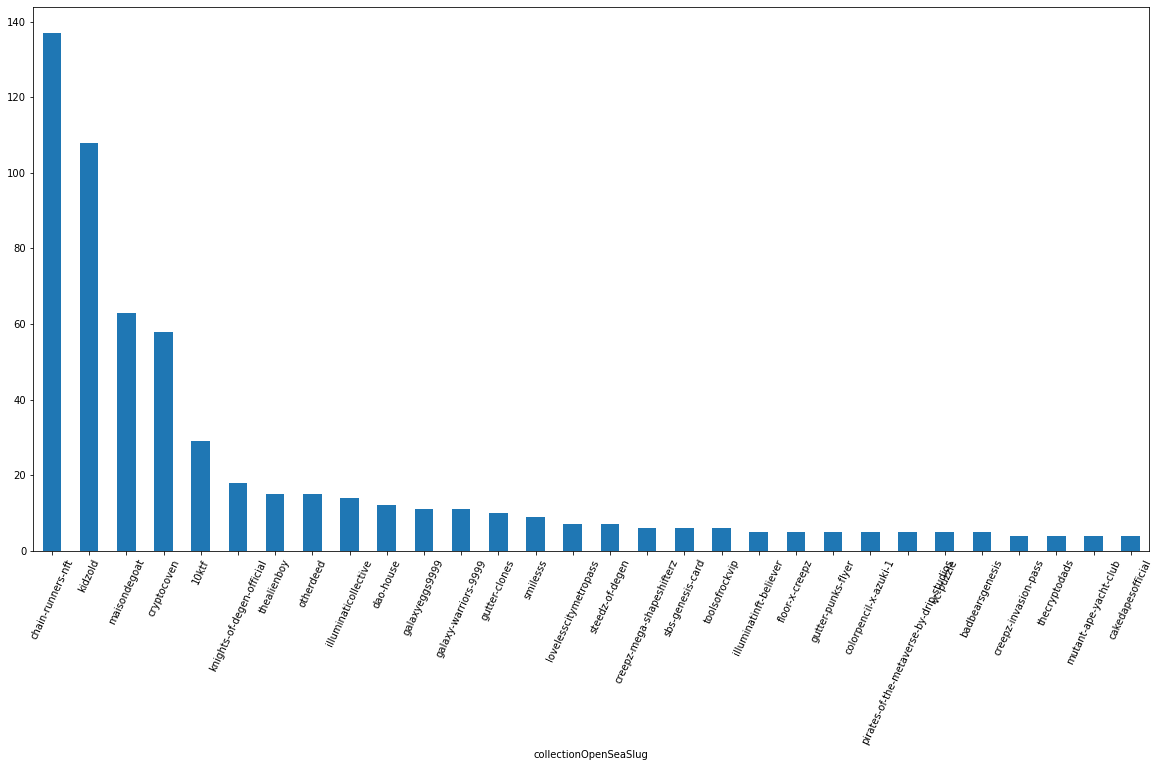

In [102]:
compare(df, "linksdao")

genesis-creepz:
 Unique owners                       : 426
 Floor price.                        : 1.23 ETH
 Total volume                        : 28199.0913576435 ETH
 floor-app  holder count             : 12
 floor-beta holder count             : 18
 floor-gen3 holder count             : 25
 Unique Floor holders across all gens: 37
 Unique Floor holders across all gens: 8.685446009389672%
 NFTs held by floor-app holders      : 22
 NFTs held by floor-beta holders     : 37
 NFTs held by floor-gen3 holders     : 42
 Number of NFTs held by Floor holders: 62
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x8dfa76a3e8f290e6224b93beba163b90449b0e38                      5
0x9e366e32b067a15a359c2c63f961ac8405cb8e2f                      4
0x5ef89f92388e309f795081e0dd83c82011ed2546                      4
0x3de78b718dd4d9a8eed2845b84513ee08a8e488f                      3
0x984bb41cebddb46585fdb16a474402b1a576aa87 

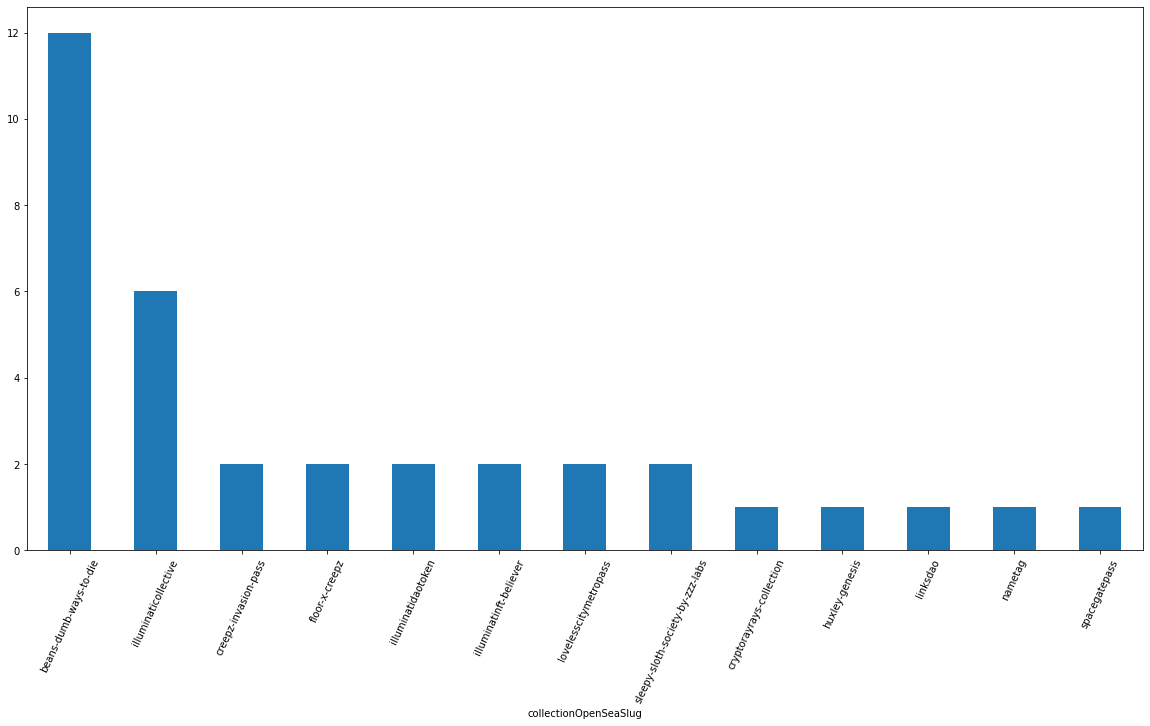

In [103]:
compare(df, "genesis-creepz")

In [104]:
compare(df, "rubber-duck-bath-party")

rubber-duck-bath-party:


IndexError: single positional indexer is out-of-bounds

starcatchersnft:
 Unique owners                       : 5530
 Floor price.                        : 0.115 ETH
 Total volume                        : 8318.07063017779 ETH
 floor-app  holder count             : 18
 floor-beta holder count             : 40
 floor-gen3 holder count             : 47
 Unique Floor holders across all gens: 82
 Unique Floor holders across all gens: 1.4828209764918625%
 NFTs held by floor-app holders      : 25
 NFTs held by floor-beta holders     : 179
 NFTs held by floor-gen3 holders     : 94
 Number of NFTs held by Floor holders: 267
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x18799f860f9adb26e076d581603037f79342e0c0                    107
0x5df064a0c99ee40171500782934b47b874462d18                     11
0x8513fafe1813b6ec3bbd9fc4baf5340bda8d670b                      9
0x7ab764b5002f355413a5107c6a15033ad2b6c31c                      8
0x3f304c6721f35ff9af00fd32650c8e0a982

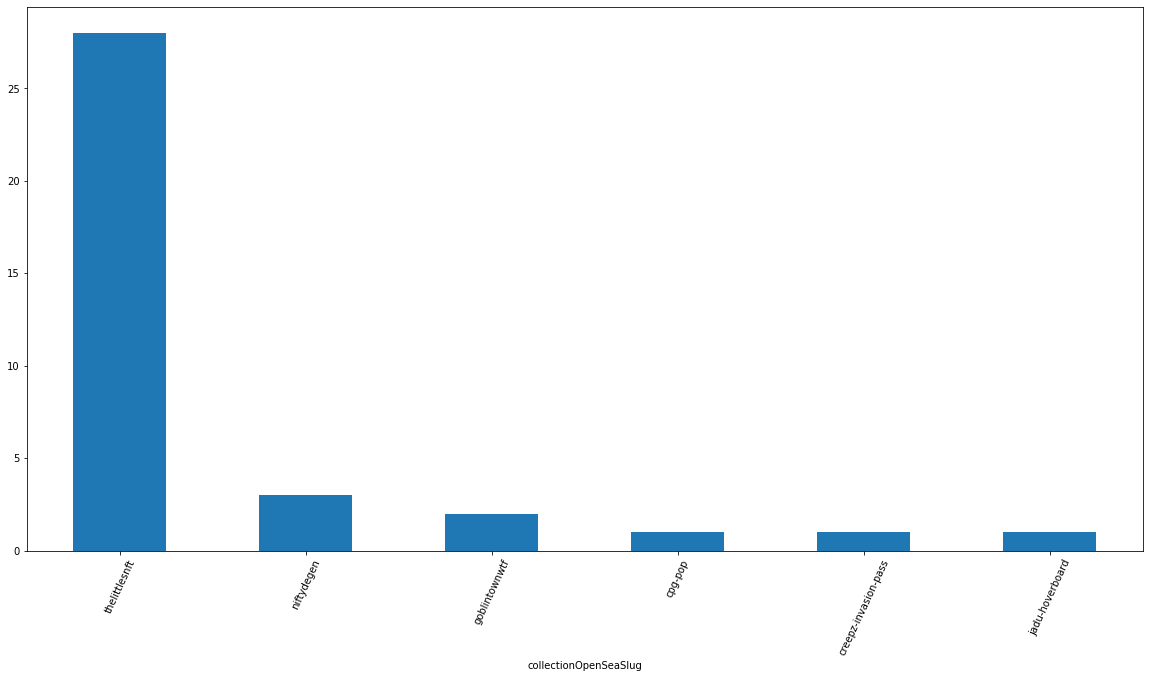

In [105]:
compare(df, "starcatchersnft")

cerealclub:
 Unique owners                       : 3721
 Floor price.                        : 0.097 ETH
 Total volume                        : 2245.22839062564 ETH
 floor-app  holder count             : 11
 floor-beta holder count             : 20
 floor-gen3 holder count             : 42
 Unique Floor holders across all gens: 52
 Unique Floor holders across all gens: 1.3974737973662994%
 NFTs held by floor-app holders      : 29
 NFTs held by floor-beta holders     : 33
 NFTs held by floor-gen3 holders     : 64
 Number of NFTs held by Floor holders: 92
                                            collectionOpenSeaSlug
ownerAddress                                                     
0xc37b1226f1be8cecb02f3ccf8dfb68f5d8374ea1                     16
0x988cd6c6a54af11e2cdf51825f59ac343e90aa62                      6
0xf4b743bd0e9867729874603402f72cfdfb85e0da                      5
0x71bc0ecf393ebe60547cee1c09e39a42199fd99f                      3
0x2e0db8f8da208bf67fec1f88a3a5096b92b00a07  

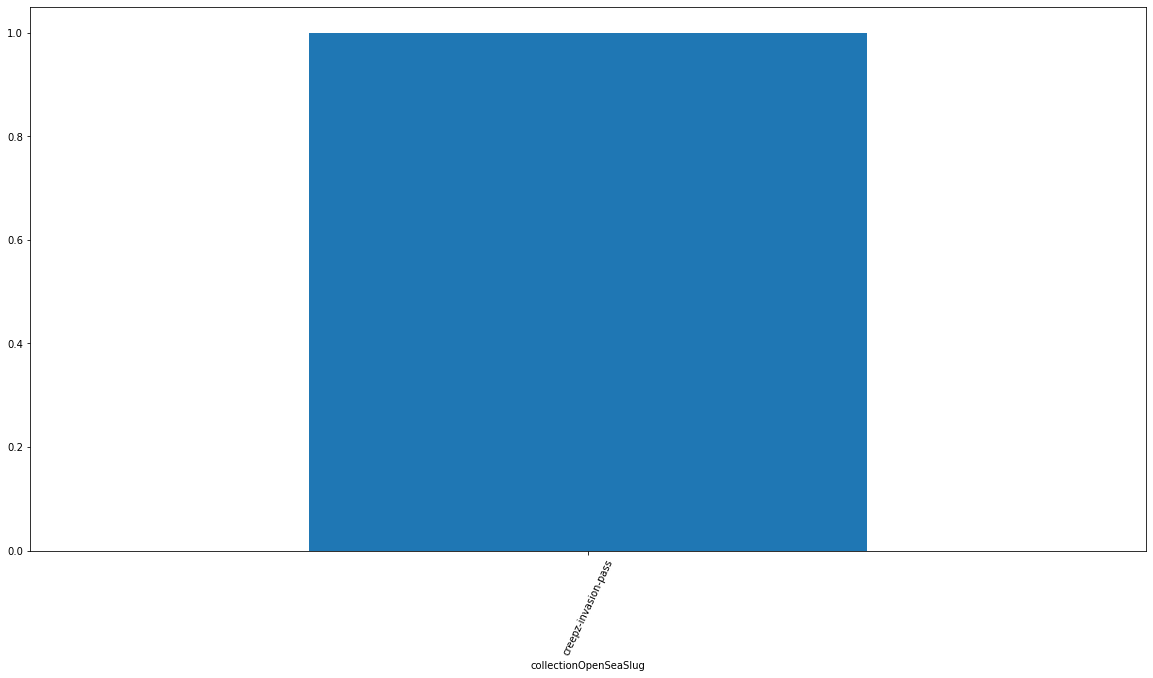

In [106]:
compare(df, "cerealclub")

In [107]:
compare(df, "woc-official")

woc-official:


IndexError: single positional indexer is out-of-bounds

bff-friendship-bracelets:
 Unique owners                       : 7065
 Floor price.                        : 0.54 ETH
 Total volume                        : 4596.28089762825 ETH
 floor-app  holder count             : 38
 floor-beta holder count             : 77
 floor-gen3 holder count             : 130
 Unique Floor holders across all gens: 181
 Unique Floor holders across all gens: 2.561924982307148%
 NFTs held by floor-app holders      : 44
 NFTs held by floor-beta holders     : 84
 NFTs held by floor-gen3 holders     : 164
 Number of NFTs held by Floor holders: 222
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x0a9c52dcce024dd72aafeb43c1c253b93ab6ee2c                     11
0x916b4145d4994601e8f37650bae0e6f4a4d88980                      5
0xb8d859418eaf164f0b581e20a10b6e628faa5e8f                      4
0x11fa0722b3e790d9974f7b5d72b11b2e6497e10f                      3
0x838e9a9e66e8b398c24db41b59

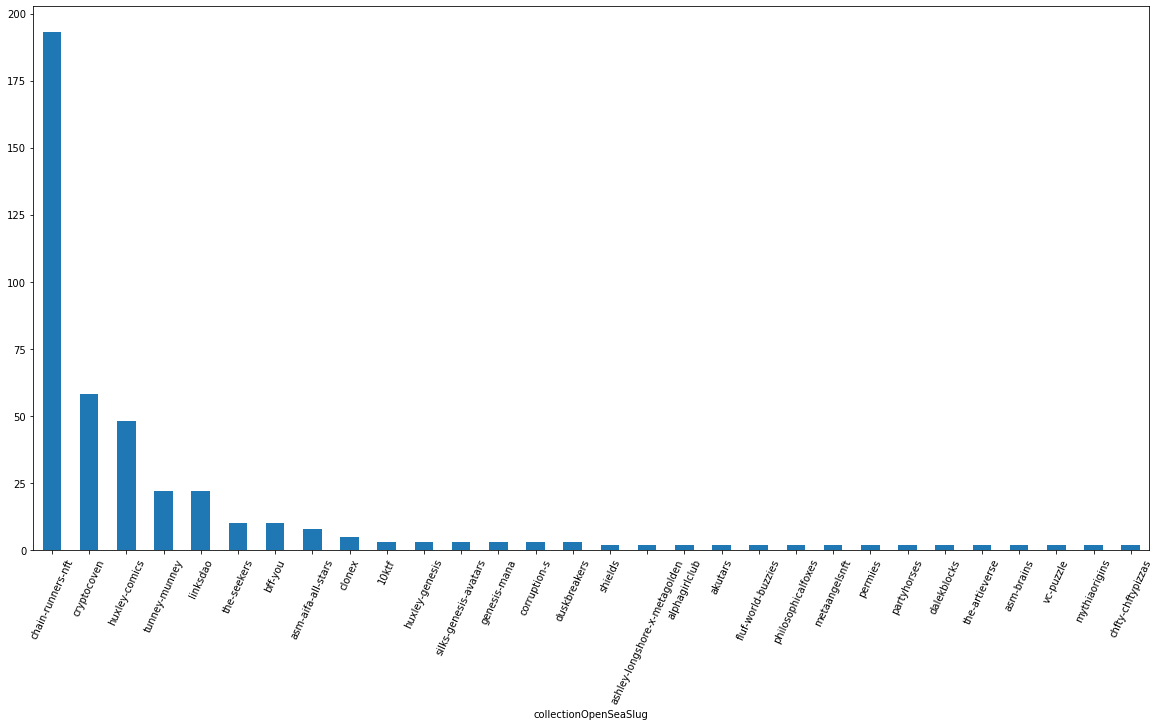

In [108]:
compare(df, "bff-friendship-bracelets")

In [109]:
compare(df, "pixl-pets-genesis")

pixl-pets-genesis:
 Unique owners                       : 3999
 Floor price.                        : 0.1388 ETH
 Total volume                        : 4153.30284600712 ETH
 floor-app  holder count             : 6
 floor-beta holder count             : 8
 floor-gen3 holder count             : 27
 Unique Floor holders across all gens: 33
 Unique Floor holders across all gens: 0.8252063015753939%
 NFTs held by floor-app holders      : 13
 NFTs held by floor-beta holders     : 36
 NFTs held by floor-gen3 holders     : 48
 Number of NFTs held by Floor holders: 79
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x5f4934fc98eae6061a01868a4700c53c1ffb7d2e                     20
0x75b464f5b62cd5a4272293531cb5a9e344da61db                      4
0x2dc92dcbcf567f5edf56ae42684e93399954755f                      3
0xdc055750c938ee4915ce8ae01957b956cda6abe8                      3
0xaf469c4a0914938e6149cf621c54fb4b1ec0

KeyError: "None of ['ownerAddress'] are in the columns"

In [110]:
compare(df, "tiny-winged-turtlez")

tiny-winged-turtlez:


IndexError: single positional indexer is out-of-bounds

In [111]:
compare(df, "shadow-quest")

shadow-quest:


IndexError: single positional indexer is out-of-bounds

lovelesscitymetropass:
 Unique owners                       : 970
 Floor price.                        : 0.092 ETH
 Total volume                        : 1701.20140964774 ETH
 floor-app  holder count             : 33
 floor-beta holder count             : 59
 floor-gen3 holder count             : 94
 Unique Floor holders across all gens: 121
 Unique Floor holders across all gens: 12.474226804123711%
 NFTs held by floor-app holders      : 43
 NFTs held by floor-beta holders     : 77
 NFTs held by floor-gen3 holders     : 137
 Number of NFTs held by Floor holders: 167
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x0c12479bcccb1023ddf9b18c904b13539c123dc4                     17
0xcf0639a8102d94ee7424e71c017379b99bc36893                      5
0x161968c79e3970851017f872fbd81cbaa1ca6c04                      4
0x01e213710b8a7ab45031c20a83c12a4bcd24ba02                      4
0x2c6b550ec68669983c6abf4fa47f3

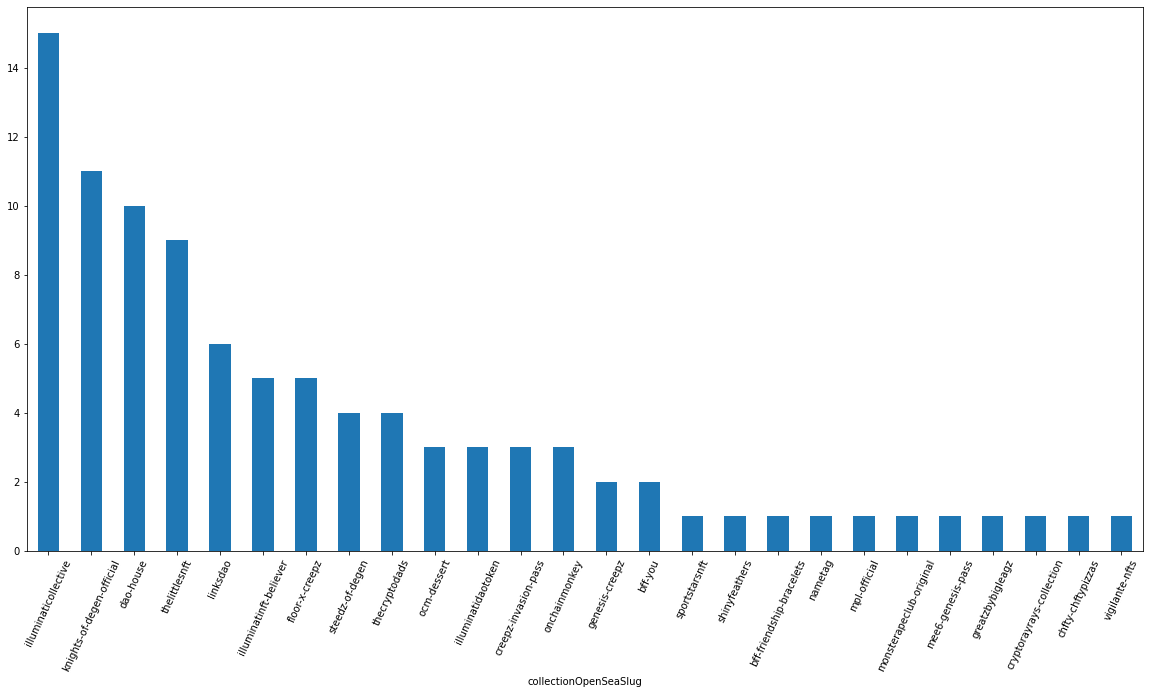

In [112]:
compare(df, "lovelesscitymetropass")

In [113]:
compare(df, "lovelesscitypassport")

lovelesscitypassport:


IndexError: single positional indexer is out-of-bounds

In [114]:
compare(df, "future-nft-mints-genesis-nft")

future-nft-mints-genesis-nft:


IndexError: single positional indexer is out-of-bounds

dao-house:
 Unique owners                       : 150
 Floor price.                        : 0.15 ETH
 Total volume                        : 2.04 ETH
 floor-app  holder count             : 18
 floor-beta holder count             : 34
 floor-gen3 holder count             : 44
 Unique Floor holders across all gens: 56
 Unique Floor holders across all gens: 37.333333333333336%
 NFTs held by floor-app holders      : 53
 NFTs held by floor-beta holders     : 76
 NFTs held by floor-gen3 holders     : 74
 Number of NFTs held by Floor holders: 104
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x1ce95deb31aeef3c4c6eb1d9ffa26bddd8a25041                     10
0xab5f4d9a90e3bb2ff4375212ea06eb99d0174c29                      9
0x1c9095dc9b6faef44a936be4a8274784e3f438f8                      6
0x29b602e754e836457c4e6fa34f1005c17d70d822                      5
0x21116b01a8ae0dc71c304bcaaeb4b8c991ef7e06                

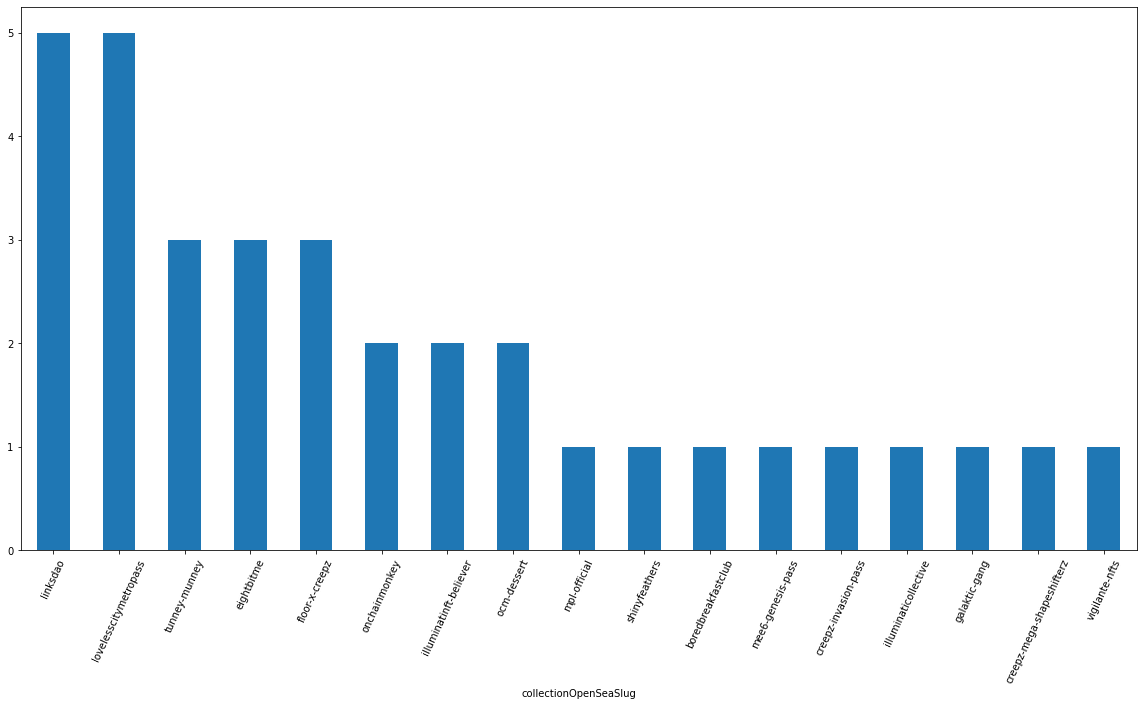

In [115]:
compare(df, "dao-house")

In [116]:
compare(df, "starwolvez-generative")

starwolvez-generative:


IndexError: single positional indexer is out-of-bounds

In [117]:
compare(df, "starwolves")

starwolves:
 Unique owners                       : 89
 Floor price.                        : 2.49 ETH
 Total volume                        : 136.992675 ETH


KeyError: "None of ['ownerAddress'] are in the columns"

premint-collector:
 Unique owners                       : 8133
 Floor price.                        : 1.527 ETH
 Total volume                        : 11490.2782748223 ETH
 floor-app  holder count             : 46
 floor-beta holder count             : 76
 floor-gen3 holder count             : 155
 Unique Floor holders across all gens: 223
 Unique Floor holders across all gens: 2.7419156522808312%
 NFTs held by floor-app holders      : 61
 NFTs held by floor-beta holders     : 83
 NFTs held by floor-gen3 holders     : 178
 Number of NFTs held by Floor holders: 263
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x886478d3cf9581b624cb35b5446693fc8a58b787                     13
0x2dbd479974967b8a0717d8b84c2172d8b26cdf44                      7
0xbc317a3460360790efcc6b04f6a613e59411c200                      4
0xa8d04cd4e1951291740ef977d56336fdc7f394c5                      4
0x961644f75e8835ba87454e247c787a2

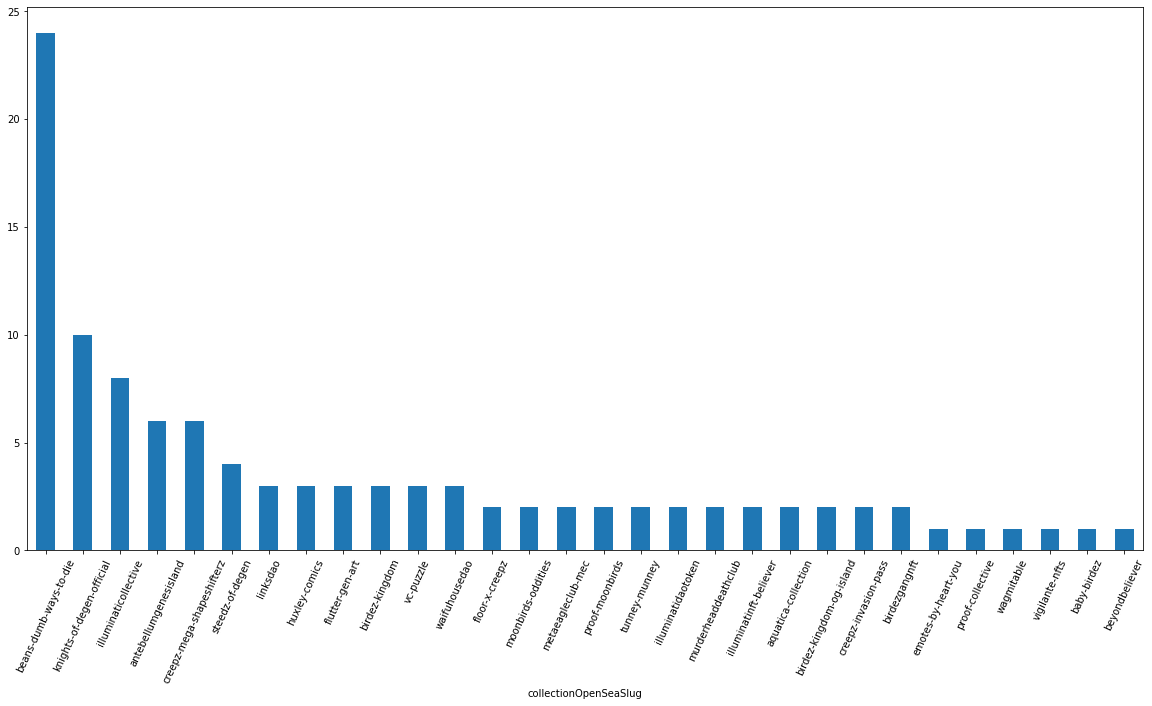

In [118]:
compare(df, "premint-collector")

In [120]:
compare(df, "premint-collector")

floor-beta:
 Unique owners                       : 680
 Floor price.                        : 0.289 ETH
 Total volume                        : 128.871686720258 ETH
 floor-app  holder count             : 119


KeyError: "None of ['ownerAddress'] are in the columns"

philosophicalfoxes:
 Unique owners                       : 703
 Floor price.                        : 0.14 ETH
 Total volume                        : 672.345798244443 ETH
 floor-app  holder count             : 4
 floor-beta holder count             : 12
 floor-gen3 holder count             : 25
 Unique Floor holders across all gens: 37
 Unique Floor holders across all gens: 5.263157894736842%
 NFTs held by floor-app holders      : 9
 NFTs held by floor-beta holders     : 30
 NFTs held by floor-gen3 holders     : 41
 Number of NFTs held by Floor holders: 66
                                            collectionOpenSeaSlug
ownerAddress                                                     
0xdc806dba2bf1eeb4ea9bee6ee254b3c371d70033                      7
0xa2efa94766ee867c91f71e8020a3c97ae687e5c3                      5
0x9ce651e89608fa270f6dc1f7931c62058d1383bf                      4
0x4e91c112f12fdeb407560fd480a5cf743979be00                      4
0x69f35bed06115dd05ab5452058d9dbe8a7ad80f

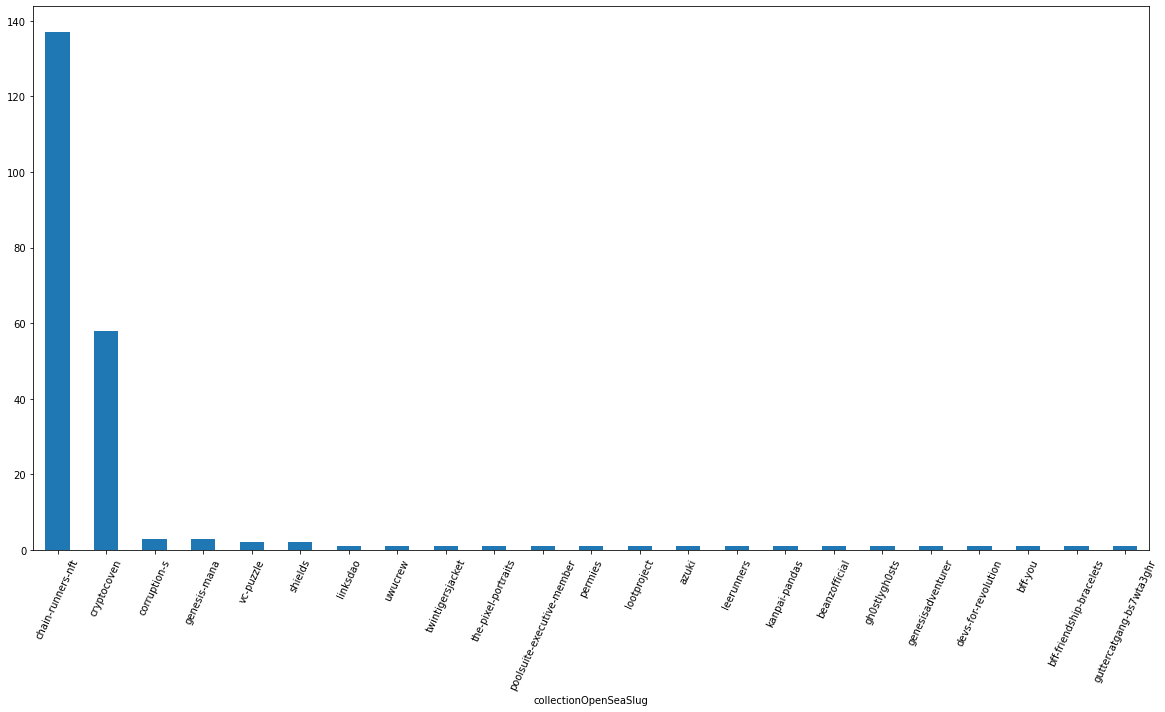

In [137]:
compare(df, "philosophicalfoxes")

tokenproof-founders-circle:
 Unique owners                       : 931
 Floor price.                        : 0.56 ETH
 Total volume                        : 370.855910607006 ETH
 floor-app  holder count             : 13
 floor-beta holder count             : 27
 floor-gen3 holder count             : 47
 Unique Floor holders across all gens: 66
 Unique Floor holders across all gens: 7.089151450053706%
 NFTs held by floor-app holders      : 16
 NFTs held by floor-beta holders     : 32
 NFTs held by floor-gen3 holders     : 57
 Number of NFTs held by Floor holders: 81
                                            collectionOpenSeaSlug
ownerAddress                                                     
0xfdd2e9e6add04693d60a6da6557aa22324115137                      3
0xa7cafd18dd8bc1e23203058d66f89f0f0ee539d9                      3
0xa6ae95184bfb3cdd554f204846aaf7b9f6232c12                      3
0x6f47ad567a09603a2812727a95528eba0fc60375                      2
0xf2e382804e9439ac176773ae94215

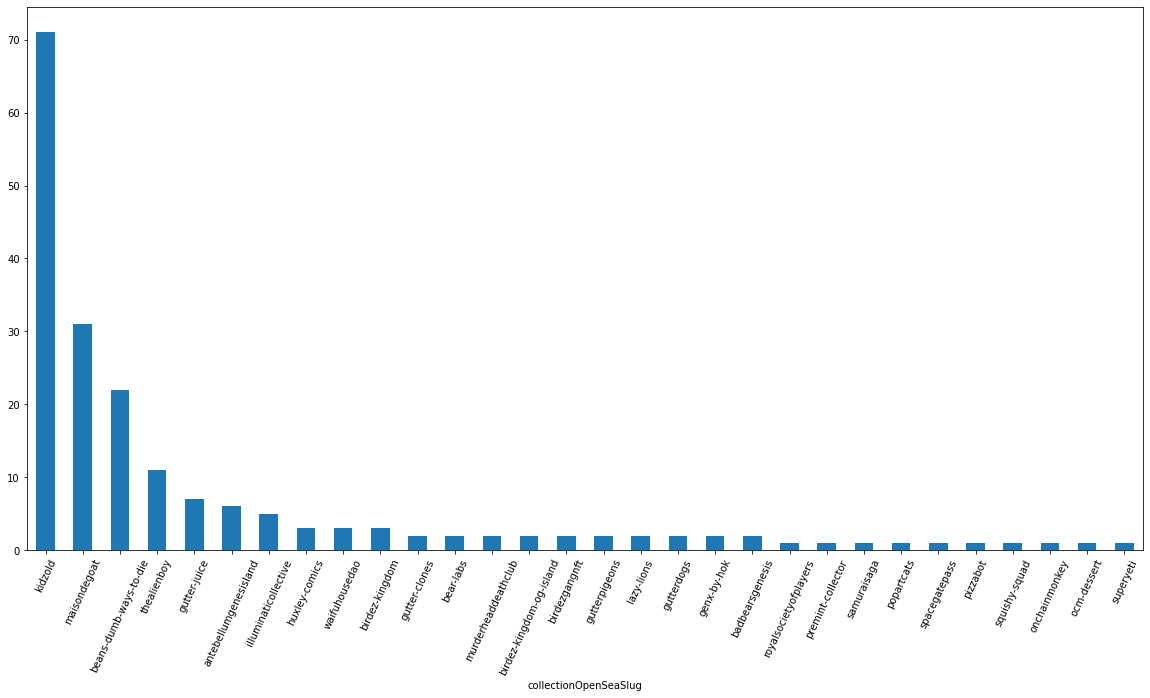

In [144]:
compare(df, "tokenproof-founders-circle")

In [145]:
def compareLight(df, slug):
    print("{}:".format(slug))
    market_data = df.query("collectionOpenSeaSlug == '{}'".format(slug)).head(1).iloc[0]
    print("{}".format(market_data['numberOfOwners']))
    print("{} ".format(market_data['floorPrice']))
    print("{} ".format(market_data['totalVolume']))
    
    print("{}".format(getSizeOfGroup(df, [slug, 'floor-app'])))
    print("{}".format(getSizeOfGroup(df, [slug, 'floor-beta'])))
    print("{}".format(getSizeOfGroup(df, [slug, 'floor-gen3'])))
    other_slug_nfts = indexed_df [ indexed_df['collectionOpenSeaSlug'] ==  slug ]
    other_slug_unique_holders_count = other_slug_nfts.index.unique().size
    other_slug_unique_holders_count
    print("{}".format(other_slug_unique_holders_count))
    print("{}%".format((other_slug_unique_holders_count/market_data['numberOfOwners'])*100))
    
    print("{}".format(nfts_held_by_floor_holders(df, slug, 'floor-app')))
    print("{}".format(nfts_held_by_floor_holders(df, slug, 'floor-beta')))
    print("{}".format(nfts_held_by_floor_holders(df, slug, 'floor-gen3')))
    illuminati_counts = pd.DataFrame(indexed_df[ indexed_df['collectionOpenSeaSlug'] == slug ].groupby('ownerAddress').count()['collectionOpenSeaSlug'])
    print("{}".format(illuminati_counts['collectionOpenSeaSlug'].sum()))
    
    print(illuminati_counts.sort_values(by='collectionOpenSeaSlug', ascending=False).head(20))
    
    df_containsIllu = similar_filtered.groupby('ownerAddress').apply(containsCollections, collections=[slug]).dropna(how='all').set_index('ownerAddress')
    df_containsIllu = df_containsIllu[ (df_containsIllu['collectionOpenSeaSlug'] != slug) ]
    
    df_containsIllu.groupby("collectionOpenSeaSlug")["collectionOpenSeaSlug"] \
    .count() \
    .sort_values(ascending=False) \
    .head(30) \
    .plot \
    .bar(figsize=(20, 10), rot=65)

In [148]:
compareLight(df, "shackled-genesis")

shackled-genesis:
405
0.06 
48.2568052887048 
2
6
11
15
3.7037037037037033%
2
16
47
61
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x886478d3cf9581b624cb35b5446693fc8a58b787                     22
0x3686a4b272c646ef6fbe34377337d95db7356e63                      9
0xe64b416c651a02f68566c7c2e38c19fae820e105                      8
0x961644f75e8835ba87454e247c787a20bc9e5278                      4
0xec6aefe1d661ad80a359533e04daf05101c09c2f                      3
0x1b525cd89fdf6142891b67c9ba07ffd754862c3d                      2
0x51ec15594230ddf21a7ea5a4ac392bb8dbda527e                      2
0x6ff7095144c856422c09102bf0606506dae6f370                      2
0xe7d254965c04468b559cbd796ee9d13b14011aa3                      2
0xf3fbb2c0a711529ef9b81fe59a5ef5b8f1e0eb27                      2
0x12c209cfb63bcaee0e31b76a345fb01e25026c2b                      1
0x7b59793ad075e4ce1e35181054759c080b8d965d             

KeyError: "None of ['ownerAddress'] are in the columns"

In [149]:
compare(df, "crypto-packaged-goods")

crypto-packaged-goods:
 Unique owners                       : 311
 Floor price.                        : 11.495 ETH
 Total volume                        : 1277.9246 ETH
 floor-app  holder count             : 9
 floor-beta holder count             : 18
 floor-gen3 holder count             : 33
 Unique Floor holders across all gens: 49
 Unique Floor holders across all gens: 15.755627009646304%
 NFTs held by floor-app holders      : 9
 NFTs held by floor-beta holders     : 18
 NFTs held by floor-gen3 holders     : 34
 Number of NFTs held by Floor holders: 50
                                            collectionOpenSeaSlug
ownerAddress                                                     
0x2920a3192613d8c42f21b64873dc0ddfcbf018d4                      2
0x0433062f9f466c4a184b2ba0e4da38efea5e2f87                      1
0xc730eb609904f7e7e1388d25dd2cb97fd5b0bec8                      1
0xa4d80978bb057b6e1afb0e47eb2b4879483c295d                      1
0xa62f3fcd3a40bff115029252e0a9b1b9d391fbd8

KeyError: "None of ['ownerAddress'] are in the columns"